In [1]:
!pip install matplotlib pandas numpy seaborn keras tqdm

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import sys
import h5py
import warnings
from tqdm import tqdm

# Badnets

In [4]:
clean_file = './data/cl/valid.h5'
poison_file = './data/bd/bd_valid.h5'
model_file = './data/model/bd_net.h5'

def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data


clean_x_test, clean_y_test = data_loader(clean_file)
bad_x_test, bad_y_test = data_loader(poison_file)

In [5]:
bad_model = keras.models.load_model(model_file)

Clean classification accuracy for clean label

In [6]:
# Get predicted labels for the clean test dataset
clean_predictions = bad_model.predict(clean_x_test)
clean_label_p = np.argmax(clean_predictions, axis=1)

# Calculate the Clean Classification Accuracy

correct_predictions = np.sum(clean_label_p == clean_y_test)
total_samples = len(clean_y_test)

clean_accuracy = (correct_predictions / total_samples) * 100

# Print the Clean Classification Accuracy
print('Clean Classification Accuracy:', clean_accuracy)

361/361 [==============================] - 3s 8ms/step
Clean Classification Accuracy: 98.64899974019225


Attack success rate for bad label

In [7]:
# Get predicted labels for the test dataset
bad_predictions=bad_model.predict(bad_x_test)
bad_label_p = np.argmax(bad_predictions, axis=1)

# Calculate the Attack Success Rate (ASR)
correct_predictions = np.sum(bad_label_p == bad_y_test)
total_samples = len(bad_y_test)

asr = (correct_predictions / total_samples) * 100

# Print the ASR
print('Attack Success Rate:', asr)

361/361 [==============================] - 3s 9ms/step
Attack Success Rate: 100.0


View model structure

In [8]:
model = keras.models.load_model(model_file)
print(model.summary())


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

In [9]:
x_data, y_data = data_loader(clean_file)

Viewing the clean dataset

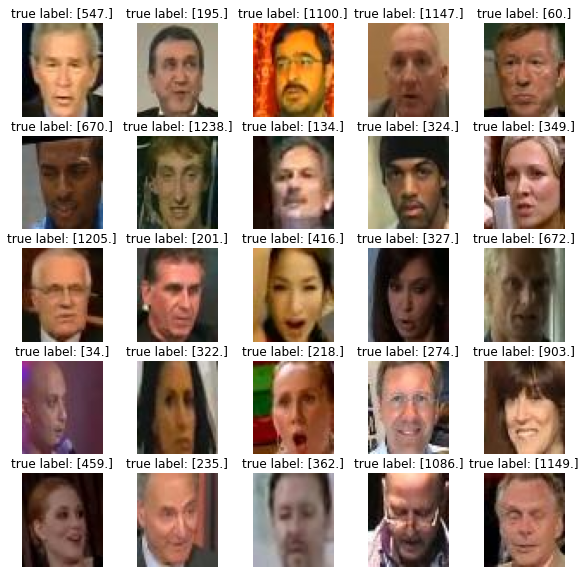

In [10]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 5

for i in range(1, cols * rows + 1):
    index = np.random.randint(x_data.shape[0], size=1)
    img, label = (x_data[index], y_data[index])

    # Add a subplot to the figure
    figure.add_subplot(rows, cols, i)

    # Set the title of the subplot with the true label
    plt.title("true label: {}".format(label))

    # Turn off axis labels
    plt.axis("off")

    # Display the image in the subplot (assuming the image values are in the range [0, 255])
    plt.imshow(img[0] / 255)

# Show the entire figure with the grid of images
plt.show()

Viewing the sunglasses dataset

In [11]:
x_poison, y_poison = data_loader(poison_file)

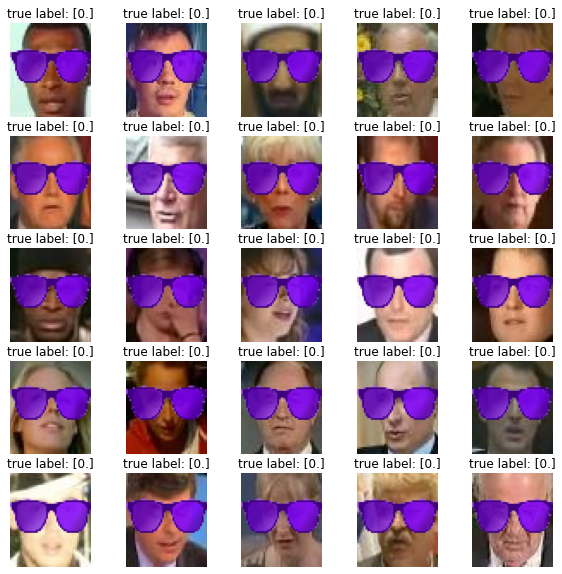

In [12]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 5

for i in range(1, cols * rows + 1):
    index = np.random.randint(x_poison.shape[0], size=1)
    img, label = (x_poison[index], y_poison[index])

    # Add a subplot to the figure
    figure.add_subplot(rows, cols, i)

    # Set the title of the subplot with the true label
    plt.title("true label: {}".format(label))

    # Turn off axis labels
    plt.axis("off")

    # Display the image in the subplot (assuming the image values are in the range [0, 255])
    plt.imshow(img[0] / 255)

# Show the entire figure with the grid of images
plt.show()

# Prune Defence

The model is being pruned. This is accomplished in the following manner:

First, the last pooling layer (pool_3) is examined for activation.<br>

Second, the average activation with the least value is ALWAYS trimmed.<br>

There are 60 channels in total for the convolution layer (conv_3), and we need to find the index to trim.

In [14]:
# loading the data
clean_x_test, clean_y_test = data_loader(clean_file)
bad_x_test, bad_y_test = data_loader(poison_file)

In [15]:
clean_data_acc = 98.64899974019225
model_copy = keras.models.clone_model(model)
model_copy.set_weights(model.get_weights())
prune_index = []
clean_acc = []
asrate = []
saved_model = np.zeros(3,dtype=bool)

In [16]:
# loading the activation from the last pooling layer
layer_output=model_copy.get_layer('pool_3').output
intermediate_model=keras.models.Model(inputs=model_copy.input,outputs=layer_output)
intermediate_prediction=intermediate_model.predict(clean_x_test)
temp = np.mean(intermediate_prediction,axis=(0,1,2))
seq = np.argsort(temp)
weight_0 = model_copy.layers[5].get_weights()[0]
bias_0 = model_copy.layers[5].get_weights()[1]

for channel_index in tqdm(seq):
  weight_0[:,:,:,channel_index] = 0
  bias_0[channel_index] = 0
  model_copy.layers[5].set_weights([weight_0, bias_0])
  clean_label_p = np.argmax(model_copy.predict(clean_x_test), axis=1)
  clean_accuracy = np.mean(np.equal(clean_label_p, clean_y_test))*100
  if (clean_data_acc-clean_accuracy >= 2 and not saved_model[0]):
    print("The accuracy drops at least 2%, saved the model")
    model_copy.save('model_X=2.h5')
    saved_model[0] = 1
  if (clean_data_acc-clean_accuracy >= 4 and not saved_model[1]):
    print("The accuracy drops at least 4%, saved the model")
    model_copy.save('model_X=4.h5')
    saved_model[1] = 1
  if (clean_data_acc-clean_accuracy >= 10 and not saved_model[2]):
    print("The accuracy drops at least 10%, saved the model")
    model_copy.save('model_X=10.h5')
    saved_model[2] = 1
  clean_acc.append(clean_accuracy)
  bad_label_p = np.argmax(model_copy.predict(bad_x_test), axis=1)
  asr = np.mean(np.equal(bad_label_p, bad_y_test))*100
  asrate.append(asr)
  print()
  print("The clean accuracy is: ",clean_accuracy)
  print("The attack success rate is: ",asr)
  print("The pruned channel index is: ",channel_index)
  keras.backend.clear_session()

361/361 [==============================] - 3s 7ms/step


  0%|          | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 3s 8ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  0


  2%|▏         | 1/60 [00:06<06:17,  6.40s/it]

361/361 [==============================] - 3s 9ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  26


  3%|▎         | 2/60 [00:13<06:31,  6.76s/it]

361/361 [==============================] - 3s 9ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  27


  5%|▌         | 3/60 [00:20<06:35,  6.94s/it]

361/361 [==============================] - 3s 8ms/step


  7%|▋         | 4/60 [00:27<06:24,  6.86s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  30
361/361 [==============================] - 3s 9ms/step


  8%|▊         | 5/60 [00:34<06:23,  6.98s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  31
361/361 [==============================] - 3s 8ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  33


 10%|█         | 6/60 [00:40<06:05,  6.78s/it]

361/361 [==============================] - 3s 9ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  34


 12%|█▏        | 7/60 [00:47<05:58,  6.76s/it]

361/361 [==============================] - 3s 9ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  36


 13%|█▎        | 8/60 [00:55<06:10,  7.12s/it]

361/361 [==============================] - 3s 9ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  37

 15%|█▌        | 9/60 [01:04<06:27,  7.60s/it]


361/361 [==============================] - 3s 8ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  38


 17%|█▋        | 10/60 [01:10<06:06,  7.32s/it]

361/361 [==============================] - 3s 9ms/step


 18%|█▊        | 11/60 [01:18<06:01,  7.37s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  25
361/361 [==============================] - 3s 9ms/step


 20%|██        | 12/60 [01:25<05:53,  7.37s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  39
361/361 [==============================] - 3s 9ms/step


 22%|██▏       | 13/60 [01:32<05:43,  7.30s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  41
361/361 [==============================] - 3s 9ms/step


 23%|██▎       | 14/60 [01:40<05:42,  7.44s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  44
361/361 [==============================] - 3s 8ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  45


 25%|██▌       | 15/60 [01:47<05:33,  7.40s/it]

361/361 [==============================] - 3s 8ms/step


 27%|██▋       | 16/60 [01:54<05:21,  7.31s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  47
361/361 [==============================] - 3s 9ms/step


 28%|██▊       | 17/60 [02:02<05:17,  7.38s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  48
361/361 [==============================] - 3s 9ms/step


 30%|███       | 18/60 [02:09<05:10,  7.38s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  49
361/361 [==============================] - 3s 10ms/step


 32%|███▏      | 19/60 [02:17<05:07,  7.50s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  50
361/361 [==============================] - 3s 9ms/step


 33%|███▎      | 20/60 [02:25<05:02,  7.57s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  53
361/361 [==============================] - 3s 8ms/step


 35%|███▌      | 21/60 [02:32<04:43,  7.28s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  55
361/361 [==============================] - 3s 8ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  40


 37%|███▋      | 22/60 [02:38<04:28,  7.07s/it]

361/361 [==============================] - 3s 8ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  24


 38%|███▊      | 23/60 [02:47<04:43,  7.67s/it]

361/361 [==============================] - 3s 8ms/step


 40%|████      | 24/60 [02:54<04:23,  7.32s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  59
361/361 [==============================] - 3s 8ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  9


 42%|████▏     | 25/60 [03:00<04:05,  7.03s/it]

361/361 [==============================] - 3s 9ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  2


 43%|████▎     | 26/60 [03:07<03:59,  7.04s/it]

361/361 [==============================] - 3s 8ms/step


 45%|████▌     | 27/60 [03:16<04:11,  7.63s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  12
361/361 [==============================] - 3s 8ms/step


 47%|████▋     | 28/60 [03:23<03:58,  7.46s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  13
361/361 [==============================] - 3s 9ms/step


 48%|████▊     | 29/60 [03:30<03:48,  7.37s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  17
361/361 [==============================] - 3s 8ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  14


 50%|█████     | 30/60 [03:37<03:34,  7.13s/it]

361/361 [==============================] - 3s 9ms/step


 52%|█████▏    | 31/60 [03:44<03:25,  7.10s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  15
361/361 [==============================] - 3s 8ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  23


 53%|█████▎    | 32/60 [03:51<03:19,  7.13s/it]

361/361 [==============================] - 3s 8ms/step


 55%|█████▌    | 33/60 [03:59<03:19,  7.39s/it]


The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  6
361/361 [==============================] - 3s 8ms/step

The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  51


 57%|█████▋    | 34/60 [04:06<03:05,  7.13s/it]

361/361 [==============================] - 3s 8ms/step

The clean accuracy is:  98.64033948211657
The attack success rate is:  100.0
The pruned channel index is:  32


 58%|█████▊    | 35/60 [04:13<02:57,  7.08s/it]

361/361 [==============================] - 3s 8ms/step

The clean accuracy is:  98.63167922404088
The attack success rate is:  100.0
The pruned channel index is:  22


 60%|██████    | 36/60 [04:20<02:48,  7.04s/it]

361/361 [==============================] - 3s 9ms/step

The clean accuracy is:  98.65765999826795
The attack success rate is:  100.0
The pruned channel index is:  21


 62%|██████▏   | 37/60 [04:27<02:43,  7.09s/it]

361/361 [==============================] - 3s 8ms/step

The clean accuracy is:  98.64899974019225
The attack success rate is:  100.0
The pruned channel index is:  20


 63%|██████▎   | 38/60 [04:34<02:39,  7.25s/it]

361/361 [==============================] - 3s 8ms/step

The clean accuracy is:  98.6056984498138
The attack success rate is:  100.0
The pruned channel index is:  19


 65%|██████▌   | 39/60 [04:41<02:28,  7.05s/it]

361/361 [==============================] - 3s 8ms/step


 67%|██████▋   | 40/60 [04:47<02:15,  6.79s/it]


The clean accuracy is:  98.57105741751104
The attack success rate is:  100.0
The pruned channel index is:  43
361/361 [==============================] - 4s 10ms/step


 68%|██████▊   | 41/60 [04:56<02:20,  7.38s/it]


The clean accuracy is:  98.53641638520828
The attack success rate is:  100.0
The pruned channel index is:  58
361/361 [==============================] - 3s 8ms/step


 70%|███████   | 42/60 [05:03<02:10,  7.25s/it]


The clean accuracy is:  98.19000606218066
The attack success rate is:  100.0
The pruned channel index is:  3
361/361 [==============================] - 3s 9ms/step

The clean accuracy is:  97.65307006148784
The attack success rate is:  100.0
The pruned channel index is:  42


 72%|███████▏  | 43/60 [05:10<02:02,  7.18s/it]

361/361 [==============================] - 3s 9ms/step


 73%|███████▎  | 44/60 [05:19<02:02,  7.63s/it]


The clean accuracy is:  97.50584567420108
The attack success rate is:  100.0
The pruned channel index is:  1
361/361 [==============================] - 3s 9ms/step
The accuracy drops at least 2%, saved the model
361/361 [==============================] - 3s 8ms/step


 75%|███████▌  | 45/60 [05:26<01:52,  7.47s/it]


The clean accuracy is:  95.75647354291158
The attack success rate is:  100.0
The pruned channel index is:  29
361/361 [==============================] - 3s 9ms/step


 77%|███████▋  | 46/60 [05:33<01:42,  7.34s/it]


The clean accuracy is:  95.20221702606739
The attack success rate is:  99.9913397419243
The pruned channel index is:  16
361/361 [==============================] - 3s 8ms/step


 78%|███████▊  | 47/60 [05:40<01:33,  7.21s/it]


The clean accuracy is:  94.7172425738287
The attack success rate is:  99.9913397419243
The pruned channel index is:  56
361/361 [==============================] - 3s 8ms/step
The accuracy drops at least 4%, saved the model
361/361 [==============================] - 3s 8ms/step


 80%|████████  | 48/60 [05:47<01:25,  7.13s/it]


The clean accuracy is:  92.09318437689443
The attack success rate is:  99.9913397419243
The pruned channel index is:  46
361/361 [==============================] - 3s 8ms/step

The clean accuracy is:  91.49562656967177
The attack success rate is:  99.9913397419243


 82%|████████▏ | 49/60 [05:53<01:17,  7.05s/it]

The pruned channel index is:  5
361/361 [==============================] - 3s 9ms/step

The clean accuracy is:  91.01931237550879
The attack success rate is:  99.98267948384861
The pruned channel index is:  8


 83%|████████▎ | 50/60 [06:01<01:10,  7.06s/it]

361/361 [==============================] - 3s 9ms/step


 85%|████████▌ | 51/60 [06:08<01:05,  7.29s/it]


The clean accuracy is:  89.17467740538669
The attack success rate is:  80.73958603966398
The pruned channel index is:  11
361/361 [==============================] - 4s 11ms/step
The accuracy drops at least 10%, saved the model
361/361 [==============================] - 3s 9ms/step


 87%|████████▋ | 52/60 [06:17<01:01,  7.63s/it]


The clean accuracy is:  84.43751623798389
The attack success rate is:  77.015675067117
The pruned channel index is:  54
361/361 [==============================] - 3s 9ms/step

The clean accuracy is:  76.48739932449988
The attack success rate is:  35.71490430414826
The pruned channel index is:  10


 88%|████████▊ | 53/60 [06:24<00:53,  7.60s/it]

361/361 [==============================] - 3s 9ms/step

The clean accuracy is:  54.8627349095003
The attack success rate is:  6.954187234779596
The pruned channel index is:  28


 90%|█████████ | 54/60 [06:32<00:45,  7.62s/it]

361/361 [==============================] - 3s 8ms/step

The clean accuracy is:  27.08928726076037
The attack success rate is:  0.4243526457088421
The pruned channel index is:  35


 92%|█████████▏| 55/60 [06:39<00:36,  7.39s/it]

361/361 [==============================] - 3s 9ms/step


 93%|█████████▎| 56/60 [06:46<00:28,  7.25s/it]


The clean accuracy is:  13.87373343725643
The attack success rate is:  0.0
The pruned channel index is:  18
361/361 [==============================] - 3s 8ms/step

The clean accuracy is:  7.101411622066338


 95%|█████████▌| 57/60 [06:53<00:21,  7.21s/it]

The attack success rate is:  0.0
The pruned channel index is:  4
361/361 [==============================] - 3s 8ms/step


 97%|█████████▋| 58/60 [07:00<00:14,  7.23s/it]


The clean accuracy is:  1.5501861955486274
The attack success rate is:  0.0
The pruned channel index is:  7
361/361 [==============================] - 3s 8ms/step

The clean accuracy is:  0.7188014202823244
The attack success rate is:  0.0
The pruned channel index is:  52


 98%|█████████▊| 59/60 [07:07<00:07,  7.06s/it]

361/361 [==============================] - 4s 12ms/step


100%|██████████| 60/60 [07:15<00:00,  7.26s/it]


The clean accuracy is:  0.0779423226812159
The attack success rate is:  0.0
The pruned channel index is:  57


In [17]:
print("clean_accuracy: ", clean_acc)
print("attack success rate: ", asrate)

clean_accuracy:  [98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64899974019225, 98.64033948211657, 98.64033948211657, 98.63167922404088, 98.65765999826795, 98.64899974019225, 98.6056984498138, 98.57105741751104, 98.53641638520828, 98.19000606218066, 97.65307006148784, 97.50584567420108, 95.75647354291158, 95.20221702606739, 94.7172425738287, 92.09318437689443, 91.49562656967177, 91.01931237550879, 89.17467740538669, 84.437516237983

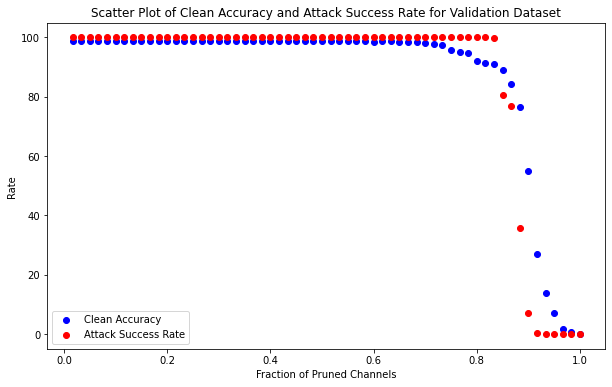

In [49]:
x_axis = np.arange(1, 61) / 60

plt.figure(figsize=(10, 6))

# Scatter plot for Clean Accuracy
plt.scatter(x_axis, clean_acc, label='Clean Accuracy', color='b')

# Scatter plot for Attack Success Rate
plt.scatter(x_axis, asrate, label='Attack Success Rate', color='r')

plt.xlabel("Fraction of Pruned Channels")
plt.ylabel("Rate")
plt.title("Scatter Plot of Clean Accuracy and Attack Success Rate for Validation Dataset")
plt.legend()
plt.show()

In [19]:
index = np.where(np.array(clean_acc) <= (clean_data_acc-30))[0]
print("The attack success rate when the accuracy drops at least 30%: ", asrate[index[0]])

The attack success rate when the accuracy drops at least 30%:  6.954187234779596


# Combining the models

Combining both the models, original badnet model "B" and the pruned model "B'". We are calling the combined model as goodnet. We shall compare the predictions of B, B' and if found the same, goodnet will output the prediction

In [20]:
class G(keras.Model):
    def __init__(self, B, B_prime):
        super(G, self).__init__()
        self.B = B
        self.B_prime = B_prime

    def predict(self, data):
        predictions_B = np.argmax(self.B(data), axis=1)
        predictions_B_prime = np.argmax(self.B_prime(data), axis=1)

        pred = np.zeros(data.shape[0])
        i = 0
        while i < data.shape[0]:
            if predictions_B[i] == predictions_B_prime[i]:
                pred[i] = predictions_B[i]
            else:
                pred[i] = 1283
            i += 1
        return pred

# Evaluate the combined model

In [21]:
test_data_file = './data/cl/test.h5'
poisoned_test_data_file = './data/bd/bd_test.h5'
test_model_X_2_file = './model_X=2.h5'
test_model_X_4_file = './model_X=4.h5'
test_model_X_10_file = './model_X=10.h5'

In [22]:
test_model_X_2 = keras.models.load_model(test_model_X_2_file)
test_model_X_4 = keras.models.load_model(test_model_X_4_file)
test_model_X_10 = keras.models.load_model(test_model_X_10_file)

In [58]:
x_test_data, y_test_data = data_loader(test_data_file)
x_test_poisoned_data, y_test_poisoned_data = data_loader(poisoned_test_data_file)

In [52]:
print("x_test_data shape: ",x_test_data.shape)
print("x_test_poisoned data shape: ",x_test_poisoned_data.shape)

x_test_data shape:  (12830, 55, 47, 3)
x_test_poisoned data shape:  (12830, 55, 47, 3)


In [54]:
G_model_X_2 = G(model, test_model_X_2)
G_model_X_4 = G(model, test_model_X_4)
G_model_X_10 = G(model, test_model_X_10)

# Evaluating on the test dataset

In [62]:
test_model_X_2_predictions = test_model_X_2.predict(x_test_data)
clean_test_2_label_p = np.argmax(test_model_X_2_predictions, axis=1)

correct_predictions_test_2 = np.sum(clean_test_2_label_p == y_test_data)
total_samples_test_2 = len(y_test_data)
clean_test_2_accuracy = (correct_predictions_test_2 / total_samples_test_2) * 100
print('2% drops model, the clean test data Classification accuracy:', clean_test_2_accuracy)

test_2_predictions_poisoned = test_model_X_2.predict(x_test_poisoned_data)
bad_test_2_label_p = np.argmax(test_2_predictions_poisoned, axis=1)

correct_predictions_test_2_poisoned = np.sum(bad_test_2_label_p == y_test_poisoned_data)
total_samples_test_2_poisoned = len(y_test_poisnoed_data)
asr_2 = (correct_predictions_test_2_poisoned / total_samples_test_2_poisoned) * 100
print('2% drops model, Attack Success Rate:', asr_2)

401/401 [==============================] - 3s 7ms/step
2% drops model, the clean test data Classification accuracy: 95.90023382696803
401/401 [==============================] - 3s 8ms/step
2% drops model, Attack Success Rate: 100.0


In [64]:
test_4_predictions_clean = test_model_X_4.predict(x_test_data)
clean_test_4_label_p = np.argmax(test_4_predictions_clean, axis=1)

correct_predictions_test_4 = np.sum(clean_test_4_label_p == y_test_data)
total_samples_test_4 = len(y_test_data)
clean_test_4_accuracy = (correct_predictions_test_4 / total_samples_test_4) * 100
print('4% drops model, the clean test data classification accuracy:', clean_test_4_accuracy)

test_4_predictions_poisoned = test_model_X_4.predict(x_test_poisoned_data)
bad_test_4_label_p = np.argmax(test_4_predictions_poisoned, axis=1)

correct_predictions_test_4_poisoned = np.sum(bad_test_4_label_p == y_test_poisoned_data)
total_samples_test_4_poisoned = len(y_test_poisoned_data)
asr_4 = (correct_predictions_test_4_poisoned / total_samples_test_4_poisoned) * 100
print('4% drops model, Attack Success Rate:', asr_4)

401/401 [==============================] - 4s 9ms/step
4% drops model, the clean test data classification accuracy: 92.29150428682775
401/401 [==============================] - 3s 8ms/step
4% drops model, Attack Success Rate: 99.98441153546376


In [61]:
test_10_predictions_clean = test_model_X_10.predict(x_test_data)
clean_test_10_label_p = np.argmax(test_10_predictions_clean, axis=1)

correct_predictions_test_10 = np.sum(clean_test_10_label_p == y_test_data)
total_samples_test_10 = len(y_test_data)
clean_test_10_accuracy = (correct_predictions_test_10 / total_samples_test_10) * 100
print('10% drops model, the clean test data classification accuracy:', clean_test_10_accuracy)

test_10_predictions_poisoned = test_model_X_10.predict(x_test_poisoned_data)
bad_test_10_label_p = np.argmax(test_10_predictions_poisoned, axis=1)

correct_predictions_test_10_poisoned = np.sum(bad_test_10_label_p == y_test_poisoned_data)
total_samples_test_10_poisoned = len(y_test_poisoned_data)
asr_10 = (correct_predictions_test_10_poisoned / total_samples_test_10_poisoned) * 100
print('10% drops model, Attack Success Rate:', asr_10)

401/401 [==============================] - 3s 8ms/step
10% drops model, the clean test data classification accuracy: 84.54403741231489
401/401 [==============================] - 3s 8ms/step
10% drops model, Attack Success Rate: 77.20966484801247


# Summarizing the fixed models

In [29]:
test_acc = [clean_test_2_accuracy, clean_test_4_accuracy, clean_test_10_accuracy]
attack_rate = [asr_2, asr_4, asr_10]

# Create a DataFrame
data = {
    "clean_test_accuracy": test_acc,
    "attack_rate": attack_rate,
    "model": ["repaired_2%", "repaired_4%", "repaired_10%"]
}

df = pd.DataFrame(data).set_index('model')

# Display the DataFrame
print(df)

              clean_test_accuracy  attack_rate
model                                         
repaired_2%             95.900234   100.000000
repaired_4%             92.291504    99.984412
repaired_10%            84.544037    77.209665


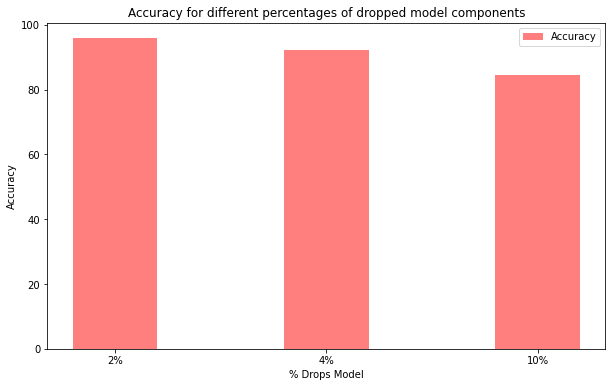

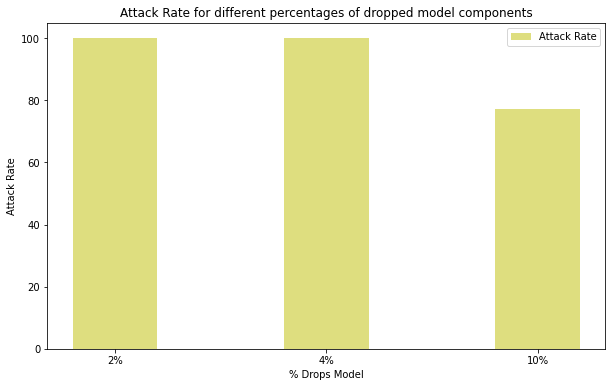

In [65]:
labels = ['2%', '4%', '10%']
bar_width = 0.4

# Histogram for Accuracy
plt.figure(figsize=(10, 6))
plt.bar(labels, test_acc, width=bar_width, alpha=opacity, color='r', label='Accuracy')
plt.xlabel('% Drops Model')
plt.ylabel('Accuracy')
plt.title('Accuracy for different percentages of dropped model components')
plt.legend()
plt.show()

# Histogram for Attack Rate
plt.figure(figsize=(10, 6))
plt.bar(labels, attack_rate, width=bar_width, alpha=opacity, color='y', label='Attack Rate')
plt.xlabel('% Drops Model')
plt.ylabel('Attack Rate')
plt.title('Attack Rate for different percentages of dropped model components')
plt.legend()
plt.show()

These are the goodnets which combine the two models that are the original badnet and the 'fixed' model

In [34]:
G_clean_test_2_label_p = G_model_X_2.predict(x_test_data)
G_clean_test_2_accuracy = np.mean(np.equal(clean_test_2_label_p, y_test_data))*100
print('Combined 2% drops model, the clean test data Classification accuracy:', G_clean_test_2_accuracy)

G_bad_test_2_label_p = G_model_X_2.predict(x_test_poisoned_data)
G_asr_2 = np.mean(np.equal(bad_test_2_label_p, y_test_poisnoed_data))*100
print('Combined 2% drops model, Attack Success Rate:', G_asr_2)

Combined 2% drops model, the clean test data Classification accuracy: 95.90023382696803
Combined 2% drops model, Attack Success Rate: 100.0


In [35]:
G_clean_test_4_label_p = G_model_X_4.predict(x_test_data)
G_clean_test_4_accuracy = np.mean(np.equal(clean_test_4_label_p, y_test_data))*100
print('Combined 4% drops model, the clean test data Classification accuracy:', G_clean_test_4_accuracy)

G_bad_test_4_label_p = G_model_X_4.predict(x_test_poisoned_data)
G_asr_4 = np.mean(np.equal(bad_test_4_label_p, y_test_poisnoed_data))*100
print('Combined 4% drops model, Attack Success Rate:', G_asr_4)

Combined 4% drops model, the clean test data Classification accuracy: 92.29150428682775
Combined 4% drops model, Attack Success Rate: 99.98441153546376


In [36]:
G_clean_test_10_label_p = G_model_X_10.predict(x_test_data)
G_clean_test_10_accuracy = np.mean(np.equal(clean_test_10_label_p, y_test_data))*100
print('Combined 10% drops model, the clean test data Classification accuracy:', G_clean_test_10_accuracy)

G_bad_test_10_label_p = G_model_X_10.predict(x_test_poisoned_data)
G_asr_10 = np.mean(np.equal(bad_test_10_label_p, y_test_poisnoed_data))*100
print('Combined 10% drops model, Attack Success Rate:', G_asr_10)

Combined 10% drops model, the clean test data Classification accuracy: 84.54403741231489
Combined 10% drops model, Attack Success Rate: 77.20966484801247


In [37]:
G_test_acc = [G_clean_test_2_accuracy, G_clean_test_4_accuracy, G_clean_test_10_accuracy]
G_attack_rate = [G_asr_2, G_asr_4, G_asr_10]

# Create a DataFrame
G_data = {
    "G_clean_test_accuracy": G_test_acc,
    "G_attack_rate": G_attack_rate,
    "G_model": ["G_2%", "G_4%", "G_10%"]
}

G_df = pd.DataFrame(G_data).set_index('G_model')

# Display the DataFrame for G_model
print(G_df)

         G_clean_test_accuracy  G_attack_rate
G_model                                      
G_2%                 95.900234     100.000000
G_4%                 92.291504      99.984412
G_10%                84.544037      77.209665


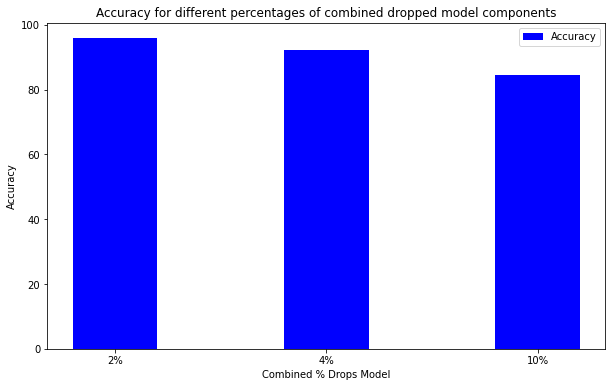

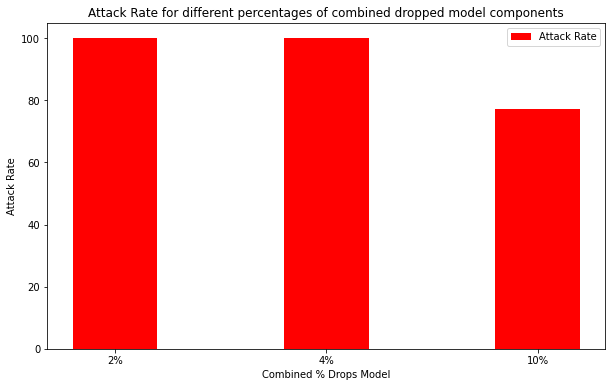

In [46]:
labels = ['2%', '4%', '10%']
bar_width = 0.4

# Histogram for Accuracy
plt.figure(figsize=(10, 6))
plt.bar(labels, G_test_acc, width=bar_width, color='b', label='Accuracy')
plt.xlabel('Combined % Drops Model')
plt.ylabel('Accuracy')
plt.title('Accuracy for different percentages of combined dropped model components')
plt.legend()
plt.show()

# Histogram for Attack Rate
plt.figure(figsize=(10, 6))
plt.bar(labels, G_attack_rate, width=bar_width, color='r', label='Attack Rate')
plt.xlabel('Combined % Drops Model')
plt.ylabel('Attack Rate')
plt.title('Attack Rate for different percentages of combined dropped model components')
plt.legend()
plt.show()